In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

In [2]:
world_tide_API_key = 'fee8ff39-48eb-42a7-bcc5-3819fce3c1e4'

def get_tide(latitude,longitude,dt64_start,dt64_end,timestep_seconds,API_key):
    #dt64_start and dt64_end are numpy datetime64 variables
    
    import requests
    import json
    import numpy as np
    import pandas as pd
    #from datetime import datetime
    from tqdm import tqdm
    
    # convert datetime64 start and end times to unix time 
    ut_start = dt64_start.astype(np.timedelta64) / np.timedelta64(1, 's') 
    ut_end = dt64_end.astype(np.timedelta64) / np.timedelta64(1, 's') 
    
    lng = ut_end-ut_start # number of seconds in record of interest
    
    # build API query
    base_url = 'https://www.worldtides.info/api/v2?heights'
    world_tide_API_key = 'fee8ff39-48eb-42a7-bcc5-3819fce3c1e4'
    query_string = 'datum=MSL&datums&heights&lat={lat}&lon={lon}&start={start}&length={length}&step={step}&key={api_key}'\
                             .format(lat = latitude,lon = longitude,start= str(int(ut_start)), length = str(int(lng)), step = str(int(timestep_seconds)), api_key = API_key)
    print('API Query:')
    print(query_string)
    url = base_url + query_string
    # hitting API and storing contents in json format
    r = requests.get(url)
    print('Reading in json file')
    json_tide = json.loads(r.text)
    print('Extracting data from json file')
    tide = []
    dt64 = np.empty(0, dtype='datetime64[ns]')
    for ii in tqdm(range(len(json_tide['heights']))):
        tide = np.append(tide, json_tide['heights'][ii]['height']) #read in tidal height and store in array
#         ut = json_tide['heights'][ii]['dt'] # read in time as unix time
#         dt = datetime.utcfromtimestamp(ut) # convert unix time to datetime
#         dt64 = np.append(dt64,np.datetime64(dt)) # convert datetime to numpy datetime64 and store in array
        ts = pd.to_datetime(json_tide['heights'][ii]['date']) # read in time as pandas time stamp
        # OK to ignore warning (I think) about converting from time zone aware pandas time stamp to
        # time zone naive numpy datetime64 because we are consistently working in UTC
        #dt64 = np.append(dt64,np.datetime64(ts)) #convert time string to numpy datetime64
        # but this way suppresses the warning just to make things less annoying
        tstr = ts.strftime('%Y-%m-%dT%H:%M:%S.%f') #convert time stamp to time string
        dt64 = np.append(dt64,np.datetime64(tstr)) #convert time string to numpy datetime64 and store in array
        
    return [dt64,tide,json_tide]

    # Do we want to use these other API parameters? What is "global background data?" - tide models?

    #stationDistance: The maximum distance (in kilometers) for which to return tidal data from a tidal station instead of from the global background data.
    #When this parameter is set to 0 no results from stations will be returned only from the global background data. This is also used with the "stations" parameter to limit the number of stations that are returned. The default for this parameter can be changed in the settings. It is set to 10km by default.

    #stations: If this parameter is present a list of tidal stations will be returned within "stationDistance" kilometers from the specified lat and lon. If stationDistance is not specified, then your default setting is used. Both lat and lon parameters are required when using this parameter.
    #The cost is 1 credit for a station distance of 500km or less, 2 credits for 5000km or less, and 3 credits for anything greater.
    #Note: This specific API call is allowed to be shared to multiple users (see License for more information).

<xarray.Dataset>
Dimensions:                        (location: 1, measurement: 140257, prediction: 1402561)
Dimensions without coordinates: location, measurement, prediction
Data variables:
    water_level_observed           (measurement) float64 ...
    time_of_water_level_observed   (measurement) datetime64[ns] ...
    water_level_predicted          (prediction) float64 ...
    time_of_water_level_predicted  (prediction) datetime64[ns] ...
    easting                        (location) float64 ...
    northing                       (location) float64 ...
    latitude                       (location) float64 ...
    longitude                      (location) float64 ...
Attributes:
    title:                     Observed and predicted water level time series...
    summary:                   Hourly observed and six-minute predicted water...
    station:                   9410230
    source:                    Extracted from https://tidesandcurrents.noaa.g...
    Conventions:            

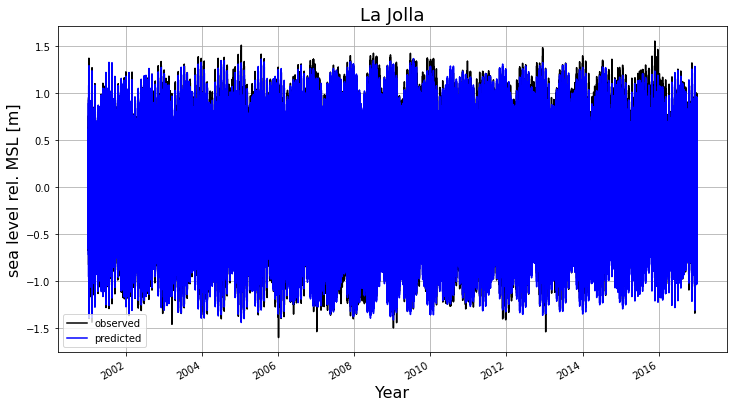

In [3]:
# look at sea level measurements for La Jolla (dataset I am familiar with)
fn ='/Users/bonnieludka/MyBeach/LudkaEtAl2019SciData/water_levels.nc' #filename
dLJ = xr.open_dataset(fn)
print(dLJ)

#lat lon
latLJ = dLJ.latitude.values
lonLJ = dLJ.longitude.values 
print('latitude:'+str(latLJ))
print('longitude:'+str(lonLJ)) 

NAVD88toMSL = .77 #https://tidesandcurrents.noaa.gov/datums.html?datum=MLLW&units=1&epoch=0&id=9410230&name=La+Jolla&state=CA

# Data array of observed La Jolla sea level (relative MSL)
da_LJ_sl_obs = xr.DataArray(dLJ.water_level_observed.values - NAVD88toMSL, 
                         dims=['date'],
                         coords={'date':dLJ.time_of_water_level_observed.values})

# Data array of predicted La Jolla sea level (relative MSL)
da_LJ_sl_pred = xr.DataArray(dLJ.water_level_predicted.values - NAVD88toMSL,
                         dims=['date'],
                         coords={'date':dLJ.time_of_water_level_predicted.values})

# time step 
print('time variable type:'+str(type(da_LJ_sl_obs[0].date.values))) #datetime64
stp_LJ_obs = np.nanmean(np.diff(da_LJ_sl_obs.date))/np.timedelta64(1, 's') 
stp_LJ_pred = np.nanmean(np.diff(da_LJ_sl_pred.date))/np.timedelta64(1, 's') 
print('time step observed (in seconds):'+str(stp_LJ_obs)) 
print('time step predicted (in seconds):'+str(stp_LJ_pred)) 

fig,ax = plt.subplots(figsize=(12, 6))
da_LJ_sl_obs.plot(color='black',label='observed')
da_LJ_sl_pred.plot(color='blue',label='predicted')
plt.xlabel('Year', fontsize=16)
plt.ylabel('sea level rel. MSL [m]', fontsize=16)
plt.title('La Jolla',fontsize=18)
plt.legend(loc='lower left')
plt.grid(True)

In [4]:
# download tide via API at La Jolla for a few months 
# (download request is too big for 6-minute predicted if I try to compare to the whole netCDF record)

# define time period of interest
dts = np.datetime64('2013-08-01')#('2013-08-26')
dte = np.datetime64('2013-09-30')#('2013-09-01')
# indentify relevant indices in "groundtruth" data 
da_LJ_sl_obs_short = da_LJ_sl_obs.sel(date=slice(dts,dte)) 
da_LJ_sl_pred_short = da_LJ_sl_pred.sel(date=slice(dts,dte)) 
# extract start and end date times
dt_obs_start = da_LJ_sl_obs_short[0].date.values
dt_obs_end = da_LJ_sl_obs_short[-1].date.values
dt_pred_start = da_LJ_sl_pred_short[0].date.values
dt_pred_end = da_LJ_sl_pred_short[-1].date.values

# get tide from API
[dt_API_LJ_obs,tide_API_LJ_obs,json_tide_LJ_obs] = get_tide(latitude = latLJ[0],longitude = lonLJ[0], \
                                         dt64_start = dt_obs_start, dt64_end = dt_obs_end, \
                                         timestep_seconds = stp_LJ_obs, API_key = world_tide_API_key)

[dt_API_LJ_pred,tide_API_LJ_pred,json_tide_LJ_pred] = get_tide(latitude = latLJ[0],longitude = lonLJ[0], \
                                         dt64_start = dt_pred_start, dt64_end = dt_pred_end, 
                                         timestep_seconds = stp_LJ_pred, API_key = world_tide_API_key)

API Query:
datum=MSL&datums&heights&lat=32.867047222222226&lon=-117.25740555555555&start=1375315200&length=5184000&step=3600&key=fee8ff39-48eb-42a7-bcc5-3819fce3c1e4


100%|██████████| 1441/1441 [00:00<00:00, 8219.16it/s]

Reading in json file
Extracting data from json file
API Query:
datum=MSL&datums&heights&lat=32.867047222222226&lon=-117.25740555555555&start=1375315200&length=5184000&step=360&key=fee8ff39-48eb-42a7-bcc5-3819fce3c1e4



 13%|█▎        | 1883/14401 [00:00<00:01, 9438.27it/s]

Reading in json file
Extracting data from json file


100%|██████████| 14401/14401 [00:01<00:00, 9167.44it/s]


In [5]:
print(dt_obs_start)
print(dt_obs_end)
print(json_tide_LJ_obs)
#note 'station' = La Jolla (Scripps Institution Wharf)
#note 'atlas' = 'NOAA'

2013-08-01T00:00:00.000000000
2013-09-30T00:00:00.000000000
{'status': 200, 'callCount': 6, 'copyright': 'Tidal data retrieved from www.worldtides.info. Copyright (c) 2014-2020 Brainware LLC. Licensed for use of individual spatial coordinates on behalf of/by an end-user. Source data created by the Center for Operational Oceanographic Products and Services (CO-OPS) and is not subject to copyright protection. NO GUARANTEES ARE MADE ABOUT THE CORRECTNESS OF THIS DATA. You may not use it if anyone or anything could come to harm as a result of using it (e.g. for navigational purposes).', 'requestLat': 32.867047222222, 'requestLon': -117.25740555556, 'responseLat': 32.8669, 'responseLon': -117.257, 'atlas': 'NOAA', 'station': 'La Jolla (Scripps Institution Wharf)', 'heights': [{'dt': 1375315200, 'date': '2013-08-01T00:00+0000', 'height': 0.7}, {'dt': 1375318800, 'date': '2013-08-01T01:00+0000', 'height': 0.721}, {'dt': 1375322400, 'date': '2013-08-01T02:00+0000', 'height': 0.635}, {'dt': 137

La Jolla (Scripps Institution Wharf)
NOAA


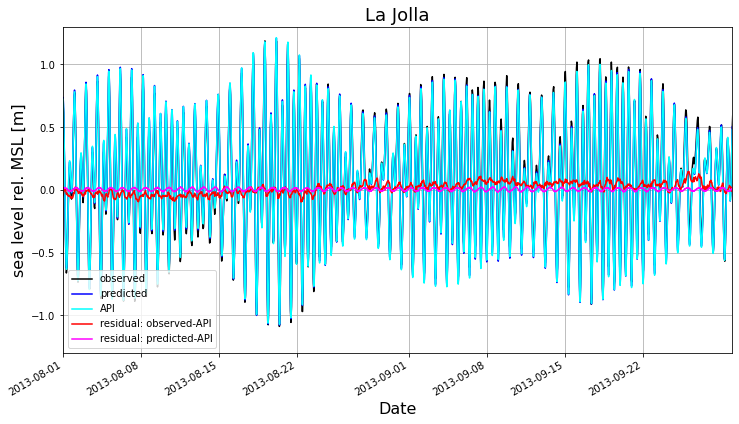

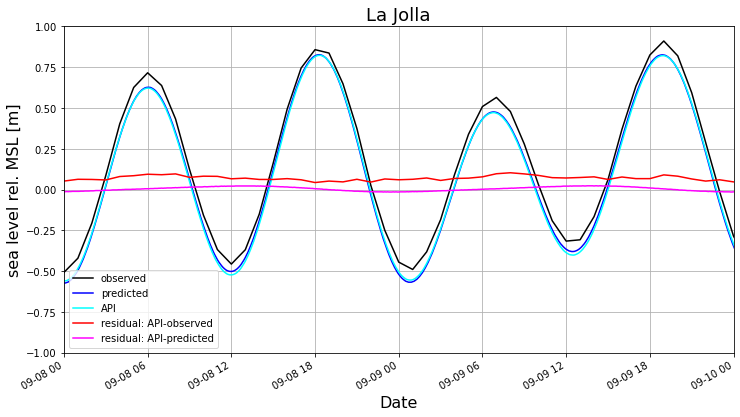

In [6]:
print(json_tide_LJ_obs['station'])
print(json_tide_LJ_obs['atlas'])

# Data array of tide API La Jolla sea level (relative MSL) with same resolution as netCDF observations
da_API_LJ_sl_obs = xr.DataArray(tide_API_LJ_obs, 
                         dims=['date'],
                         coords={'date':dt_API_LJ_obs})

# Data array of tide API La Jolla sea level (relative MSL) with same resolution as netCDF predictions
da_API_LJ_sl_pred = xr.DataArray(tide_API_LJ_pred, 
                         dims=['date'],
                         coords={'date':dt_API_LJ_pred})

# residuals 
res_LJ_obs = da_LJ_sl_obs - da_API_LJ_sl_obs
res_LJ_pred = da_LJ_sl_pred - da_API_LJ_sl_pred

# make time series comparison plot
fig,ax = plt.subplots(figsize=(12, 6))
da_LJ_sl_obs.plot(color='black',label='observed')
da_LJ_sl_pred.plot(color='blue',label='predicted')
da_API_LJ_sl_pred.plot(color='cyan',label='API')
res_LJ_obs.plot(color='red',label='residual: observed-API')
res_LJ_pred.plot(color='magenta',label='residual: predicted-API')
plt.xlim(dts, dte)
plt.ylim(-1.3,1.3)
plt.xlabel('Date', fontsize=16)
plt.ylabel('sea level rel. MSL [m]', fontsize=16)
plt.title('La Jolla',fontsize=18)
plt.legend(loc='lower left')
plt.grid(True)

# zoom in to look at offset
dtzs = np.datetime64('2013-09-08') 
dtze = np.datetime64('2013-09-10')
fig,ax = plt.subplots(figsize=(12, 6))
da_LJ_sl_obs.plot(color='black',label='observed')
da_LJ_sl_pred.plot(color='blue',label='predicted')
da_API_LJ_sl_pred.plot(color='cyan',label='API')
res_LJ_obs.plot(color='red',label='residual: API-observed')
res_LJ_pred.plot(color='magenta',label='residual: API-predicted')
plt.xlim(dtzs, dtze)
plt.ylim(-1,1)
plt.xlabel('Date', fontsize=16)
plt.ylabel('sea level rel. MSL [m]', fontsize=16)
plt.title('La Jolla',fontsize=18)
plt.legend(loc='lower left')
plt.grid(True)


<xarray.Dataset>
Dimensions:               (record_id: 1, time: 163592)
Coordinates:
  * time                  (time) datetime64[ns] 2002-06-04T16:00:00.028800 .....
  * record_id             (record_id) int16 2570
Data variables:
    sea_level             (record_id, time) float32 ...
    lat                   (record_id) float32 ...
    lon                   (record_id) float32 ...
    station_name          (record_id) |S16 ...
    station_country       (record_id) |S13 ...
    station_country_code  (record_id) float32 ...
    uhslc_id              (record_id) int16 ...
    gloss_id              (record_id) float32 ...
    ssc_id                (record_id) |S4 ...
    last_rq_date          (record_id) datetime64[ns] ...
Attributes:
    title:                  UHSLC Fast Delivery Tide Gauge Data (hourly)
    ncei_template_version:  NCEI_NetCDF_TimeSeries_Orthogonal_Template_v2.0
    featureType:            timeSeries
    Conventions:            CF-1.6, ACDD-1.3
    date_created:      

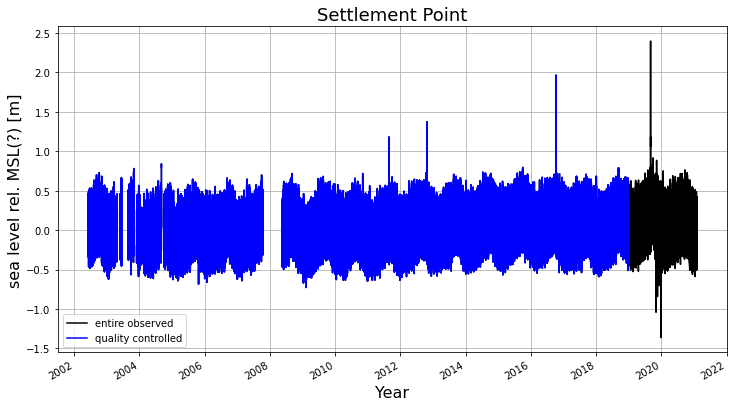

In [7]:
# look at sea level measurements for Settlement Point (closest tide gauge to Abaco Bight)
# using the "Fast Delivery" dataset to get most recent data including for Hurricane Dorian
# http://uhslc.soest.hawaii.edu/data/?fd
fn ='/Users/bonnieludka/Spaceship/IceSAT2/analysis_distribute/projects/abaco_bight/data/settlement_point_water_levels_hourly.nc'
dSP = xr.open_dataset(fn)
print(dSP)

#lat lon
latSP = dSP.lat.values
lonSP = dSP.lon.values 
print('latitude:'+str(latSP))
# longitude value is incorrect??? 281.017 ?? 
# Not a simple difference of 180 degrees... not sure what is going on
print('longitude (incorrect in file?):'+str(lonSP)) 
lonSP= [-78.98300] # from 
print('corrected longitude:'+str(lonSP))

### THIS DID NOT HELP
# Try this instead?? to match exact station location according to API?
# latSP = [26.7167]
# print('latitude according to API:'+str(latSP))
# lonSP = [-79]
# print('longitude according to API:'+str(lonSP))

dtSP = dSP.time.values #datetime64
stpSP = np.nanmin(np.diff(dtSP))/np.timedelta64(1, 's') 

# Data array of observed Settlement Point sea level
MSL = np.nanmean(dSP.sea_level[0,:].values)/1000
print('MSL='+str(MSL)+'m')
da_SP_sl = xr.DataArray((dSP.sea_level[0,:].values/1000) - MSL, #convert sea level measurements from mm to meters and shift so that zero is at MSL
                         dims=['date'],
                         coords={'date':dSP.time.values})

da_SP_sl_rq = da_SP_sl.sel(date=slice(dSP.time[0],dSP.last_rq_date[0])) #quality controlled ("research quality") part of the record

# time step 
print('time variable type:'+str(type(da_SP_sl[0].date.values))) #datetime64
stp_SP = np.nanmin(np.diff(da_SP_sl.date))/np.timedelta64(1, 's') 
print('time step (in seconds):'+str(stp_SP)) 
# should I round this?
stp_SP = np.rint(stp_SP)

fig,ax = plt.subplots(figsize=(12, 6))
da_SP_sl.plot(color='black',label='entire observed')
da_SP_sl_rq.plot(color='blue',label='quality controlled')
plt.xlabel('Year', fontsize=16)
plt.ylabel('sea level rel. MSL(?) [m]', fontsize=16)
plt.title('Settlement Point',fontsize=18)
plt.legend(loc='lower left')
plt.grid(True)

#other useful info?:
#There was another tide gauge at Settlement Point (about 3 miles away) from 1985-2002. Might want to look at that record as well? Could be tricky to combine records because looks like datums shifted
#Datums info? Doesn't seem to match the MSL I am getting for the more recent record?...
#https://www.psmsl.org/data/obtaining/rlr.diagrams/1646.php
#more metadata: https://www.psmsl.org/data/obtaining/stations/1646.php
#https://www.gloss-sealevel.org/gloss-station-handbook?stn=211


In [8]:
# look at API data over entire record - THIS TAKES A WHILE!
# get tide from API
[dt_API_SP,tide_API_SP,json_tide_SP] = get_tide(latitude = latSP[0],longitude = lonSP[0], \
                                         dt64_start = da_SP_sl[0].date.values, dt64_end = da_SP_sl[-1].date.values, \
                                         timestep_seconds = stp_SP, API_key = world_tide_API_key)

API Query:
datum=MSL&datums&heights&lat=26.690000534057617&lon=-78.983&start=1023206400&length=588927599&step=3600&key=fee8ff39-48eb-42a7-bcc5-3819fce3c1e4


  1%|          | 1885/163591 [00:00<00:17, 9420.11it/s]

Reading in json file
Extracting data from json file


100%|██████████| 163591/163591 [00:31<00:00, 5215.96it/s]


In [9]:
print(da_SP_sl[0].date.values)
print(dt_API_SP[0])
print(da_SP_sl[-1].date.values)
print(dt_API_SP[-1])


2002-06-04T16:00:00.028800000
2002-06-04T16:00:00.000000000
2021-01-31T22:59:59.971200000
2021-01-31T22:00:00.000000000


Settlement Point
FES
26.690000534058
26.7167
-78.983
-79


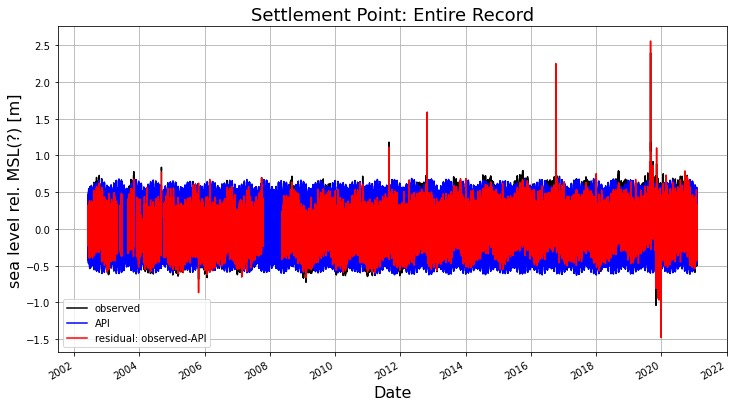

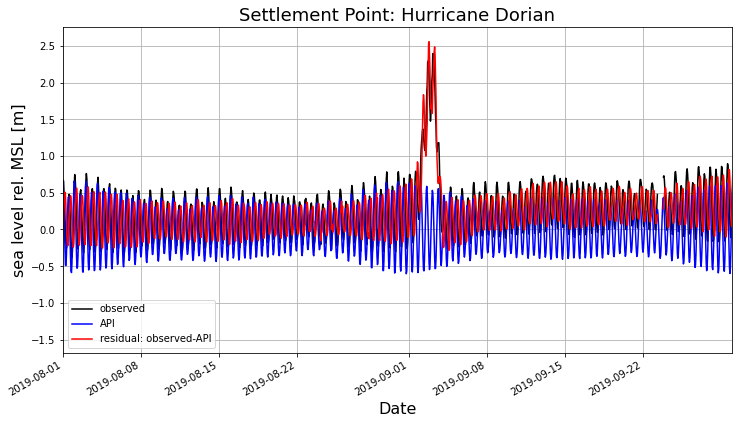

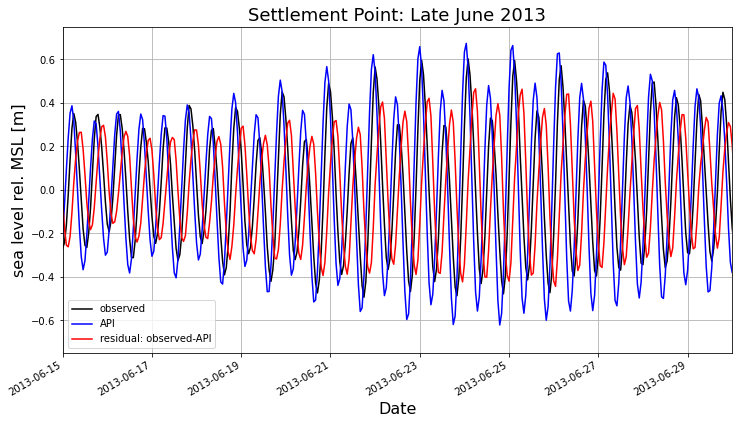

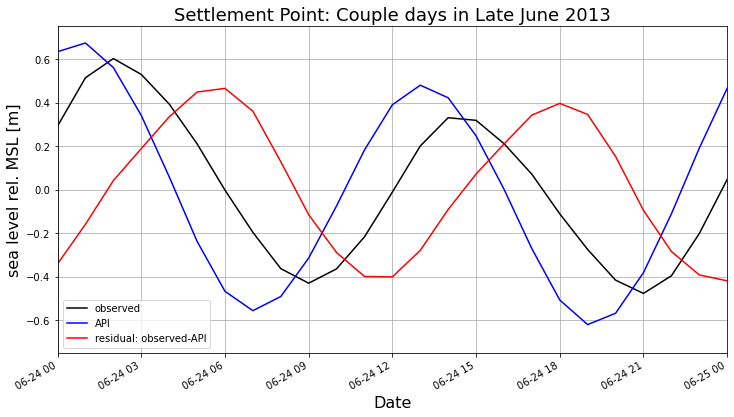

In [10]:
print(json_tide_SP['station'])
#note the API says it is using 'station': 'Settlement Point'
print(json_tide_SP['atlas'])
#'atlas:' 'FES'  = Finite Element Solution?
print(json_tide_SP['requestLat'])
print(json_tide_SP['responseLat'])
print(json_tide_SP['requestLon'])
print(json_tide_SP['responseLon'])

# Data array of tide API Settlement Point sea level (relative MSL) with same resolution as netCDF observations
da_API_SP_sl = xr.DataArray(tide_API_SP, 
                         dims=['date'],
                         coords={'date':dt_API_SP})

da_API_SP_sl_intp = da_API_SP_sl.interp(date=da_SP_sl.date)
# residual
res_SP = da_SP_sl - da_API_SP_sl_intp

# make time series comparison plot
fig,ax = plt.subplots(figsize=(12, 6))
da_SP_sl.plot(color='black',label='observed')
da_API_SP_sl.plot(color='blue',label='API')
res_SP.plot(color='red',label='residual: observed-API')
plt.xlabel('Date', fontsize=16)
plt.ylabel('sea level rel. MSL(?) [m]', fontsize=16)
plt.title('Settlement Point: Entire Record',fontsize=18)
plt.legend(loc='lower left')
plt.grid(True)

# look at time period around Hurricane Dorian
dtzs = np.datetime64('2019-08-01') 
dtze = np.datetime64('2019-09-30') 
fig,ax = plt.subplots(figsize=(12, 6))
da_SP_sl.plot(color='black',label='observed')
da_API_SP_sl.plot(color='blue',label='API')
res_SP.plot(color='red',label='residual: observed-API')
plt.xlim(dtzs, dtze)
plt.xlabel('Date', fontsize=16)
plt.ylabel('sea level rel. MSL [m]', fontsize=16)
plt.title('Settlement Point: Hurricane Dorian',fontsize=18)
plt.legend(loc='lower left')
plt.grid(True)

# while trouble shooting use part of grouth truth record we know has been quality controlled
dtzs = np.datetime64('2013-06-15') 
dtze = np.datetime64('2013-06-30')
fig,ax = plt.subplots(figsize=(12, 6))
da_SP_sl.plot(color='black',label='observed')
da_API_SP_sl.plot(color='blue',label='API')
res_SP.plot(color='red',label='residual: observed-API')
plt.xlim(dtzs, dtze)
plt.ylim(-.75,.75)
plt.xlabel('Date', fontsize=16)
plt.ylabel('sea level rel. MSL [m]', fontsize=16)
plt.title('Settlement Point: Late June 2013',fontsize=18)
plt.legend(loc='lower left')
plt.grid(True)

# zoom in to look at offset
dtzs = np.datetime64('2013-06-24') 
dtze = np.datetime64('2013-06-25')
fig,ax = plt.subplots(figsize=(12, 6))
da_SP_sl.plot(color='black',label='observed')
da_API_SP_sl.plot(color='blue',label='API')
res_SP.plot(color='red',label='residual: observed-API')
plt.xlim(dtzs, dtze)
plt.ylim(-.75,.75)
plt.xlabel('Date', fontsize=16)
plt.ylabel('sea level rel. MSL [m]', fontsize=16)
plt.title('Settlement Point: Couple days in Late June 2013', fontsize=18)
plt.legend(loc='lower left')
plt.grid(True)

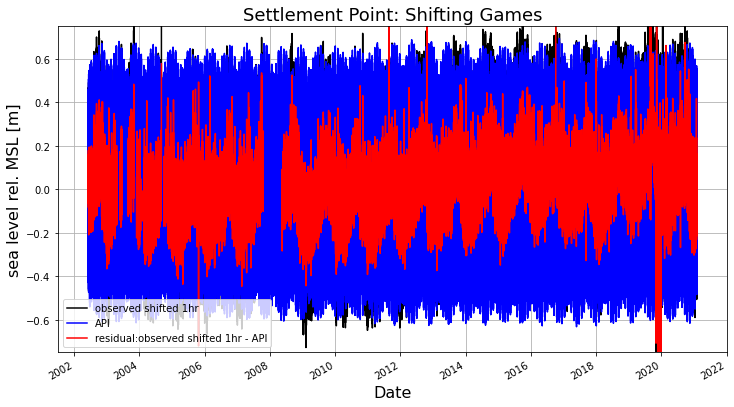

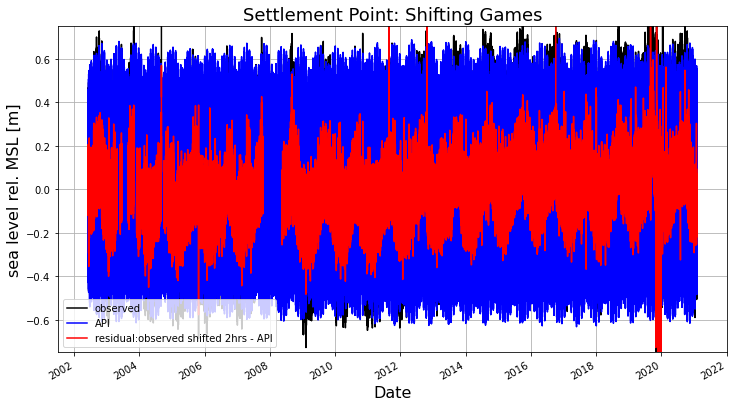

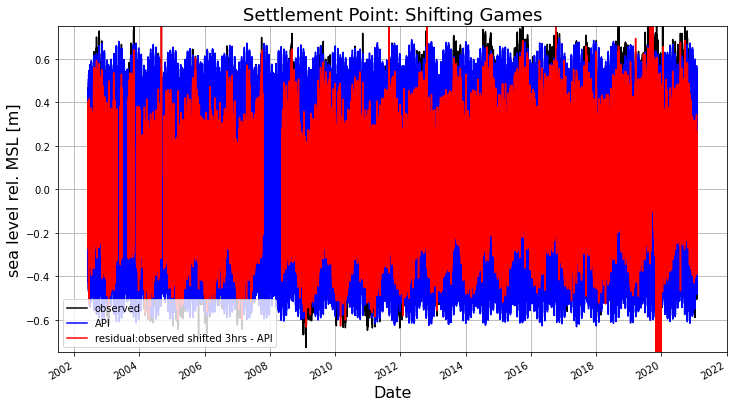

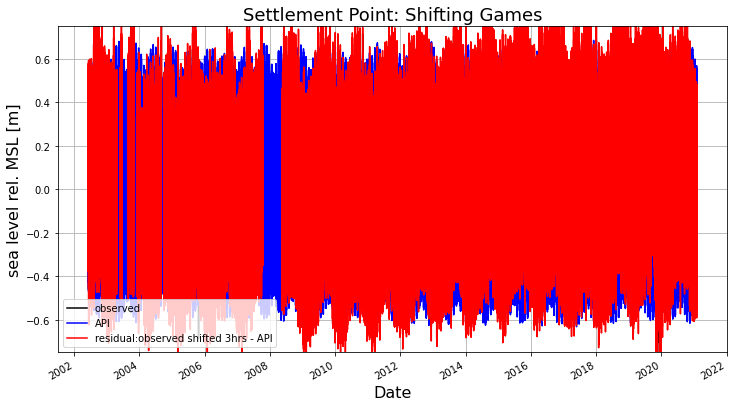

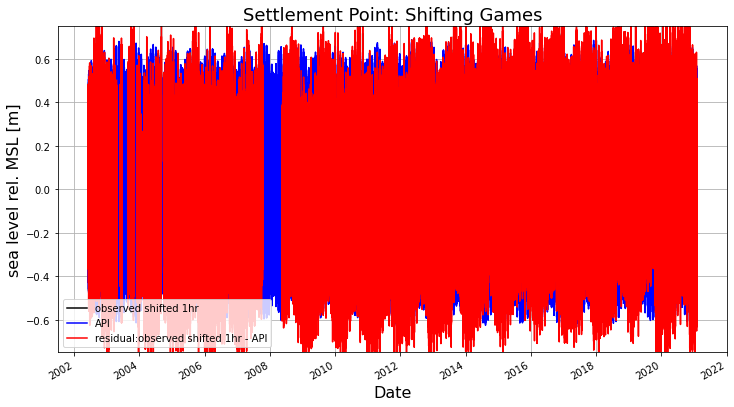

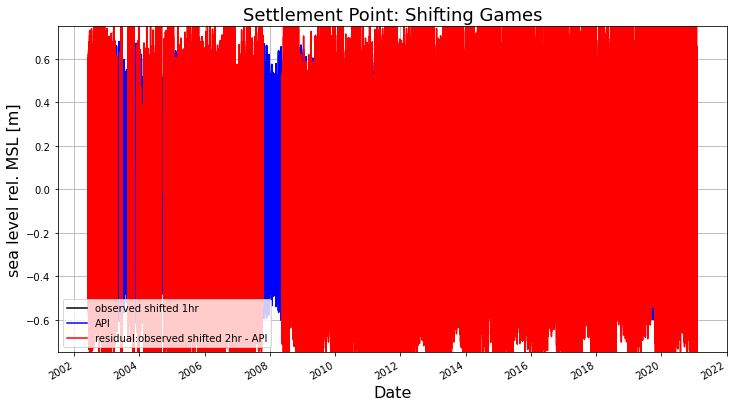

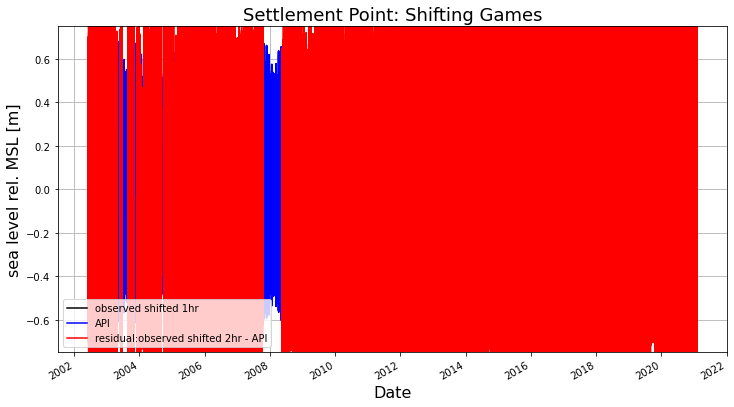

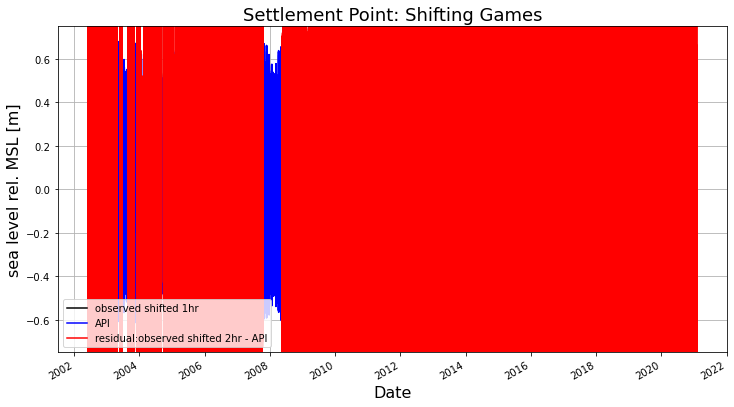

In [11]:
# can we reconcile differences with a simple time offset?

# Time series seem offset by ~1.5 hours??

# shifted one hour
fig,ax = plt.subplots(figsize=(12, 6))
plt.plot(da_SP_sl.date[0:-2].values,da_SP_sl[1:-1].values,color='black',label='observed shifted 1hr')
da_API_SP_sl.plot(color='blue',label='API')
res_SP_shift1 = da_SP_sl[1:-1].values - da_API_SP_sl_intp[0:-2].values
plt.plot(da_SP_sl.date[0:-2].values, res_SP_shift1,color='red',label='residual:observed shifted 1hr - API')
#plt.xlim(dtzs, dtze)
plt.ylim(-.75,.75)
plt.xlabel('Date', fontsize=16)
plt.ylabel('sea level rel. MSL [m]', fontsize=16)
plt.title('Settlement Point: Shifting Games', fontsize=18)
plt.legend(loc='lower left')
plt.grid(True)

#shifted 2 hours
fig,ax = plt.subplots(figsize=(12, 6))
plt.plot(da_SP_sl.date[0:-3].values,da_SP_sl[2:-1].values,color='black',label='observed')
da_API_SP_sl.plot(color='blue',label='API')
res_SP_shift2 = da_SP_sl[2:-1].values - da_API_SP_sl_intp[0:-3].values
plt.plot(da_SP_sl.date[0:-3].values, res_SP_shift2,color='red',label='residual:observed shifted 2hrs - API')
#plt.xlim(dtzs, dtze)
plt.ylim(-.75,.75)
plt.xlabel('Date', fontsize=16)
plt.ylabel('sea level rel. MSL [m]', fontsize=16)
plt.title('Settlement Point: Shifting Games', fontsize=18)
plt.legend(loc='lower left')
plt.grid(True)

#shifted 3 hours
fig,ax = plt.subplots(figsize=(12, 6))
plt.plot(da_SP_sl.date[0:-4].values,da_SP_sl[3:-1].values,color='black',label='observed')
da_API_SP_sl.plot(color='blue',label='API')
res_SP_shift3 = da_SP_sl[3:-1].values - da_API_SP_sl_intp[0:-4].values
plt.plot(da_SP_sl.date[0:-4].values, res_SP_shift3,color='red',label='residual:observed shifted 3hrs - API')
#plt.xlim(dtzs, dtze)
plt.ylim(-.75,.75)
plt.xlabel('Date', fontsize=16)
plt.ylabel('sea level rel. MSL [m]', fontsize=16)
plt.title('Settlement Point: Shifting Games', fontsize=18)
plt.legend(loc='lower left')
plt.grid(True)

#shifted 4 hours
fig,ax = plt.subplots(figsize=(12, 6))
plt.plot(da_SP_sl.date[0:-5].values,da_SP_sl[4:-1].values,color='black',label='observed')
da_API_SP_sl.plot(color='blue',label='API')
res_SP_shift4 = da_SP_sl[4:-1].values - da_API_SP_sl_intp[0:-5].values
plt.plot(da_SP_sl.date[0:-5].values, res_SP_shift4,color='red',label='residual:observed shifted 3hrs - API')
#plt.xlim(dtzs, dtze)
plt.ylim(-.75,.75)
plt.xlabel('Date', fontsize=16)
plt.ylabel('sea level rel. MSL [m]', fontsize=16)
plt.title('Settlement Point: Shifting Games', fontsize=18)
plt.legend(loc='lower left')
plt.grid(True)

# Try shifting other direction
# shifted one hour
fig,ax = plt.subplots(figsize=(12, 6))
plt.plot(da_SP_sl.date[1:-1].values,da_SP_sl[0:-2].values,color='black',label='observed shifted 1hr')
da_API_SP_sl.plot(color='blue',label='API')
res_SP_shift1r = da_SP_sl[0:-2].values - da_API_SP_sl_intp[1:-1].values
plt.plot(da_SP_sl.date[1:-1].values, res_SP_shift1r,color='red',label='residual:observed shifted 1hr - API')
#plt.xlim(dtzs, dtze)
plt.ylim(-.75,.75)
plt.xlabel('Date', fontsize=16)
plt.ylabel('sea level rel. MSL [m]', fontsize=16)
plt.title('Settlement Point: Shifting Games', fontsize=18)
plt.legend(loc='lower left')
plt.grid(True)

# shifted two hours
fig,ax = plt.subplots(figsize=(12, 6))
plt.plot(da_SP_sl.date[2:-1].values,da_SP_sl[0:-3].values,color='black',label='observed shifted 1hr')
da_API_SP_sl.plot(color='blue',label='API')
res_SP_shift2r = da_SP_sl[0:-3].values - da_API_SP_sl_intp[2:-1].values
plt.plot(da_SP_sl.date[2:-1].values, res_SP_shift2r,color='red',label='residual:observed shifted 2hr - API')
#plt.xlim(dtzs, dtze)
plt.ylim(-.75,.75)
plt.xlabel('Date', fontsize=16)
plt.ylabel('sea level rel. MSL [m]', fontsize=16)
plt.title('Settlement Point: Shifting Games', fontsize=18)
plt.legend(loc='lower left')
plt.grid(True)

# shifted three hours
fig,ax = plt.subplots(figsize=(12, 6))
plt.plot(da_SP_sl.date[3:-1].values,da_SP_sl[0:-4].values,color='black',label='observed shifted 1hr')
da_API_SP_sl.plot(color='blue',label='API')
res_SP_shift3r = da_SP_sl[0:-4].values - da_API_SP_sl_intp[3:-1].values
plt.plot(da_SP_sl.date[3:-1].values, res_SP_shift3r,color='red',label='residual:observed shifted 2hr - API')
#plt.xlim(dtzs, dtze)
plt.ylim(-.75,.75)
plt.xlabel('Date', fontsize=16)
plt.ylabel('sea level rel. MSL [m]', fontsize=16)
plt.title('Settlement Point: Shifting Games', fontsize=18)
plt.legend(loc='lower left')
plt.grid(True)

# shifted four hours
fig,ax = plt.subplots(figsize=(12, 6))
plt.plot(da_SP_sl.date[4:-1].values,da_SP_sl[0:-5].values,color='black',label='observed shifted 1hr')
da_API_SP_sl.plot(color='blue',label='API')
res_SP_shift4r = da_SP_sl[0:-5].values - da_API_SP_sl_intp[4:-1].values
plt.plot(da_SP_sl.date[4:-1].values, res_SP_shift4r,color='red',label='residual:observed shifted 2hr - API')
#plt.xlim(dtzs, dtze)
plt.ylim(-.75,.75)
plt.xlabel('Date', fontsize=16)
plt.ylabel('sea level rel. MSL [m]', fontsize=16)
plt.title('Settlement Point: Shifting Games', fontsize=18)
plt.legend(loc='lower left')
plt.grid(True)

In [5]:
import pyTMD

DistributionNotFound: The 'pyTMD' distribution was not found and is required by the application